## Basic Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import random
import json
import csv
import seaborn as sns
from datetime import datetime
%matplotlib inline

from PIL import Image
import io

import cv2

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

from datasets import load_dataset

from typing import Callable, Optional, List, Dict

import difflib

# docTR imports
from doctr.models import ocr_predictor

# Configure device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

/Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
No GPU available, using CPU


## Load CORD-v2 Dataset

In [2]:
# Load CORD-v2 dataset
print("Loading CORD-v2 dataset from Hugging Face:")
ds = load_dataset("naver-clova-ix/cord-v2")

print("Dataset loaded successfully!")
print("Dataset structure:")
print(ds)

# Show dataset splits
print("Available splits:")
for split in ds.keys():
    print(f"    - {split}: {len(ds[split])} samples")

Loading CORD-v2 dataset from Hugging Face:
Dataset loaded successfully!
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})
Available splits:
    - train: 800 samples
    - validation: 100 samples
    - test: 100 samples
Dataset loaded successfully!
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})
Available splits:
    - train: 800 samples
    - validation: 100 samples
    - test: 100 samples


## Image Preprocessing for docTR

docTR requires minimal preprocessing since the model handles most transformations internally. We define a preprocessor class that supports multiple strategies for image enhancement.

In [3]:
class DocTRPreprocessor:
    """Image preprocessing for docTR OCR."""

    @staticmethod
    def _ensure_rgb(img_np: np.ndarray) -> np.ndarray:
        """Ensure image is uint8 RGB HxWx3."""
        if img_np.ndim == 2:  # grayscale HxW
            img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
        elif img_np.ndim == 3 and img_np.shape[2] == 1:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
        # If already HxWx3, leave as is
        return img_np.astype(np.uint8)

    @staticmethod
    def preprocess_image(image, preprocess_type: str = "raw") -> np.ndarray:
        """
        Preprocess image for docTR recognition.

        Args:
            image: PIL Image or path string
            preprocess_type: "raw", "default", "simple_threshold", "grayscale", "enhanced"

        Returns:
            Preprocessed image as numpy array H x W x 3, uint8 RGB
        """
        # Convert to numpy (handle both PIL and path strings)
        if isinstance(image, str):
            img_np = cv2.imread(image)
            img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        else:
            # HF CORD "image" is a PIL image already
            img_np = np.array(image)

        # Treat "default" as "raw" for safety/backward compat
        if preprocess_type in ("raw", "default"):
            return DocTRPreprocessor._ensure_rgb(img_np)

        if preprocess_type == "grayscale":
            if img_np.ndim == 3:
                gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            else:
                gray = img_np
            gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
            return DocTRPreprocessor._ensure_rgb(gray_rgb)

        if preprocess_type == "simple_threshold":
            if img_np.ndim == 3:
                gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            else:
                gray = img_np
            _, threshold = cv2.threshold(
                gray, thresh=0, maxval=255,
                type=cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )
            threshold_rgb = cv2.cvtColor(threshold, cv2.COLOR_GRAY2RGB)
            return DocTRPreprocessor._ensure_rgb(threshold_rgb)

        if preprocess_type == "enhanced":
            # Typical "receipt" pipeline: denoise + Otsu
            if img_np.ndim == 3:
                gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            else:
                gray = img_np
            denoised = cv2.fastNlMeansDenoising(
                gray, None, h=10,
                templateWindowSize=7,
                searchWindowSize=21
            )
            _, threshold = cv2.threshold(
                denoised, thresh=0, maxval=255,
                type=cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )
            threshold_rgb = cv2.cvtColor(threshold, cv2.COLOR_GRAY2RGB)
            return DocTRPreprocessor._ensure_rgb(threshold_rgb)

        # Fallback: just ensure RGB
        return DocTRPreprocessor._ensure_rgb(img_np)


# Initialize preprocessor
preprocessor = DocTRPreprocessor()
print("DocTR Preprocessor initialized successfully")

DocTR Preprocessor initialized successfully


# docTR: Document Text Recognition for Receipt OCR
---
docTR (Document Text Recognition) is an end-to-end deep learning OCR system specifically designed for document understanding. Unlike traditional OCR engines like PyTesseract or EasyOCR, docTR is pre-trained on millions of document images and preserves spatial structure, making it ideal for receipts. This notebook evaluates docTR's pre-trained performance on the CORD-v2 receipt dataset without any fine-tuning, establishing a strong baseline for comparison with our fine-tuned TrOCR and Donut models.

## Why docTR for Receipt OCR?

Traditional OCR engines struggle with receipt-specific challenges:
- **Thermal printing degradation**: Faded text, variable quality
- **Complex layouts**: Multi-column formats and lists of items with aligned prices
- **Mixed content**: Numbers, symbols ($, #, %), text, and special characters
- **Variable fonts and sizes**: Different stores use different printing systems

docTR addresses these challenges through:
- **Two-stage architecture**: Separate detection and recognition models
- **Document-aware training**: Pre-trained on structured documents, not just general text
- **Spatial structure preservation**: Maintains layout information

## docTR Architecture

docTR uses a **pipeline of two specialized neural networks**:

1. **Text Detection: DB-ResNet50**
  - **DB (Differentiable Binarization)**: State-of-the-art text detection method
  - **ResNet-50 backbone**: Deep convolutional network (50 layers) for feature extraction
  - **Function**: Locates text regions in the image and generates bounding boxes
  - **Output**: List of bounding boxes [(x1, y1, x2, y2), ...] for each word or line

2. **Text Recognition: CRNN-VGG16-BN**
  - **CRNN**: Convolutional Recurrent Neural Network
    - **CNN part (VGG16)**: Extracts visual features from cropped text regions
    - **RNN part (LSTM)**: Processes feature sequence to recognize character sequence
    - **CTC decoder**: Converts LSTM outputs to final text
  - **Batch Normalization (BN)**: Stabilizes training and improves convergence
  - **Function**: Converts each bounding box image to text
  - **Output**: Recognized text for each region

## Three Evaluation Strategies
We evaluate docTR with three different configurations to find the optimal balance between speed and accuracy:

### **Strategy 1: Default (DB-ResNet50 + CRNN-VGG16-BN)**
- **Detection**: DB-ResNet50
- **Recognition**: CRNN-VGG16-BN
- **Preprocessing**: Raw images, no manual processing

## docTR Dataset Preparation

docTR requires images in numpy array format (H × W × 3, uint8, RGB). We create a custom dataset that:
1. Loads receipt images from CORD-v2
2. Extracts ground truth text from JSON annotations
3. Applies optional preprocessing
4. Returns images in docTR-compatible format

The dataset extracts all text from CORD-v2's structured annotations by iterating through `valid_line` then `words` then `text` fields and joining them into a single string.

In [4]:
class DocTRDataset(Dataset):
    """Dataset wrapper for CORD-v2 with docTR-compatible format."""

    def __init__(
        self,
        hf_split,
        preprocess_type: str = "raw",
    ):
        self.hf_split = hf_split
        self.preprocess_type = preprocess_type
        self.preprocessor = DocTRPreprocessor()

    @staticmethod
    def extract_text_from_ground_truth(ground_truth) -> str:
        """Extract all text from CORD ground truth JSON."""
        try:
            if isinstance(ground_truth, str):
                gt_dict = json.loads(ground_truth)
            else:
                gt_dict = ground_truth

            text_lines: List[str] = []
            if "valid_line" in gt_dict:
                for line in gt_dict["valid_line"]:
                    for word in line.get("words", []):
                        txt = word.get("text", "")
                        if txt:
                            text_lines.append(txt)

            full_text = " ".join(text_lines)
            return full_text.strip()
        except Exception:
            return ""

    def __len__(self) -> int:
        return len(self.hf_split)

    def __getitem__(self, idx: int) -> Dict:
        sample = self.hf_split[idx]
        image_pil: Image.Image = sample["image"]

        # Preprocess image to RGB np.ndarray
        image_np = self.preprocessor.preprocess_image(
            image_pil, self.preprocess_type
        )

        # Extract ground truth text
        text = self.extract_text_from_ground_truth(sample["ground_truth"])

        return {
            "image": image_np, # np.ndarray HxWx3 (RGB)
            "text": text, # GT text
            "image_pil": image_pil # for debugging/visualization
        }


# Test dataset creation
print("Creating docTR test dataset...")
doctr_test_dataset = DocTRDataset(
    hf_split=ds['test'],
    preprocess_type="raw"
)

print(f"Dataset created successfully!")
print(f"Total samples: {len(doctr_test_dataset)}")

# Test sample
test_sample = doctr_test_dataset[0]
print(f"\nSample output:")
print(f"    - Image shape: {test_sample['image'].shape}")
print(f"    - Ground truth preview: {test_sample['text'][:100]}...")
print(f"docTR Dataset ready!")

Creating docTR test dataset...
Dataset created successfully!
Total samples: 100

Sample output:
    - Image shape: (648, 432, 3)
    - Ground truth preview: 901016 -TICKET CP 2 60.000 60.000 TOTAL DISC $ -60.000 TAX 5.455 Subtotal 60.000 TOTAL 60.000 (Qty 2...
docTR Dataset ready!


## docTR DataModule with PyTorch Lightning

We use PyTorch Lightning's `LightningDataModule` to organize data loading logic. This provides:
- **Automatic batching**: Handles variable-size images through custom collate function
- **Multi-worker loading**: Parallel data loading for faster training
- **Reproducibility**: Consistent data handling across experiments

The custom `collate_fn` is necessary because docTR processes images individually, no fixed-size tensors, so we keep images as a list of numpy arrays rather than stacking them into a batch tensor.

In [5]:
class DocTRDataModule(L.LightningDataModule):
    """PyTorch Lightning DataModule for docTR evaluation."""

    def __init__(
        self,
        hf_dataset,
        batch_size: int = 4,
        num_workers: int = 4,
        preprocess_type: str = "raw",
    ):
        super().__init__()
        self.hf_dataset = hf_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.preprocess_type = preprocess_type

    def setup(self, stage=None):
        """Setup train/val/test datasets."""
        if stage in ("fit", None, "validate"):
            self.train_dataset = DocTRDataset(
                self.hf_dataset["train"],
                preprocess_type=self.preprocess_type,
            )
            self.val_dataset = DocTRDataset(
                self.hf_dataset["validation"],
                preprocess_type=self.preprocess_type,
            )

        if stage in ("test", None):
            self.test_dataset = DocTRDataset(
                self.hf_dataset["test"],
                preprocess_type=self.preprocess_type,
            )

    @staticmethod
    def collate_fn(batch):
        """Custom collate function to handle variable-size images."""
        images = [item["image"] for item in batch]
        texts = [item["text"] for item in batch]
        images_pil = [item["image_pil"] for item in batch]

        return {
            "images": images,
            "texts": texts,
            "images_pil": images_pil
        }

    def _loader(self, dataset, shuffle: bool) -> DataLoader:
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collate_fn
        )

    def train_dataloader(self):
        return self._loader(self.train_dataset, shuffle=True)

    def val_dataloader(self):
        return self._loader(self.val_dataset, shuffle=False)

    def test_dataloader(self):
        return self._loader(self.test_dataset, shuffle=False)


print("DocTR DataModule defined successfully")

DocTR DataModule defined successfully


## docTR Lightning Model Implementation

We wrap docTR's OCR predictor in a PyTorch Lightning module for evaluation:

**Model Initialization:**
- `ocr_predictor()` loads pre-trained weights for both detection and recognition
- Models are moved to GPU if available
- No gradient computation needed, since we are only evaluating

**Metrics:**
- **Character-level accuracy**: Uses `difflib.SequenceMatcher` to compute similarity ratio
- More robust than exact string matching, since it handles small OCR errors 
- Formula: `similarity = matching_characters / total_characters`

**Inference Process:**
1. Pass numpy image array to `self.model([image_np])`
2. docTR returns hierarchical structure: `pages → blocks → lines → words`
3. Extract all word values and join them with spaces
4. Compare against ground truth using difflib

**Why this metric?**
Unlike exact match (0% or 100%), character-level similarity captures partial correctness:
- "TOTAL $12.39" vs "TOTAL $12.3Q" = ~94% (one character error)
- More informative for analyzing model performance on receipt text

In [ ]:
class DocTRLightningModel(L.LightningModule):
    """
    docTR OCR wrapper with PyTorch Lightning for receipt OCR.
    """
    def __init__(
        self,
        det_arch: str = "db_resnet50",
        reco_arch: str = "crnn_vgg16_bn",
        pretrained: bool = True,
        use_gpu: bool = True,
        learning_rate: float = 2e-5,
    ):
        super().__init__()
        self.save_hyperparameters()

        print(f"Initializing docTR with det_arch={det_arch}, reco_arch={reco_arch}")

        # Initialize docTR OCR predictor
        self.model = ocr_predictor(
            det_arch=det_arch,
            reco_arch=reco_arch,
            pretrained=pretrained
        )

        # Move to GPU if available
        if use_gpu and torch.cuda.is_available():
            self.model = self.model.cuda()
            print("docTR predictor moved to GPU")

        # Store predictions / GT for epoch-level metrics
        self.val_predictions: List[str] = []
        self.val_ground_truths: List[str] = []
        self.test_predictions: List[str] = []
        self.test_ground_truths: List[str] = []

    def forward(self, image_np: np.ndarray) -> str:
        """Run docTR OCR inference on a single numpy RGB image."""
        try:
            # Ensure uint8 HxWx3
            if isinstance(image_np, Image.Image):
                image_np = np.array(image_np)
            if image_np.ndim == 2:
                image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
            image_np = image_np.astype(np.uint8)

            # Directly pass numpy page as in official docs
            result = self.model([image_np])

            # Iterate structured result
            full_text_tokens: List[str] = []
            for page in result.pages:
                for block in page.blocks:
                    for line in block.lines:
                        for word in line.words:
                            full_text_tokens.append(word.value)

            text = " ".join(full_text_tokens).strip()
            return text

        except Exception as e:
            print(f"docTR inference failed: {e}")
            return ""

    @staticmethod
    def calculate_character_accuracy(pred: str, gt: str) -> float:
        """Character-level similarity using difflib, robust to small shifts."""
        if not gt:
            return 0.0
        matcher = difflib.SequenceMatcher(None, gt, pred)
        return matcher.ratio()

    def training_step(self, batch, batch_idx):
        """
        Return a dummy loss for Lightning compatibility.
        """
        loss = torch.tensor(0.0, requires_grad=True)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step, run docTR inference and compare to ground truth."""
        images = batch["images"]
        texts = batch["texts"]

        batch_accs: List[float] = []

        for image_np, gt_text in zip(images, texts):
            pred_text = self.forward(image_np)

            acc = self.calculate_character_accuracy(pred_text, gt_text)
            batch_accs.append(acc)

            self.val_predictions.append(pred_text)
            self.val_ground_truths.append(gt_text)

        avg_acc = float(sum(batch_accs) / len(batch_accs)) if batch_accs else 0.0
        self.log(
            "val_acc",
            avg_acc,
            prog_bar=True,
            on_step=True,
            on_epoch=True,
            batch_size=len(images),
        )
        return {"val_acc": avg_acc}

    def test_step(self, batch, batch_idx):
        """Test step, run docTR inference and save all predictions."""
        images = batch["images"]
        texts = batch["texts"]

        batch_accs: List[float] = []

        for image_np, gt_text in zip(images, texts):
            pred_text = self.forward(image_np)

            acc = self.calculate_character_accuracy(pred_text, gt_text)
            batch_accs.append(acc)

            self.test_predictions.append(pred_text)
            self.test_ground_truths.append(gt_text)

        avg_acc = float(sum(batch_accs) / len(batch_accs)) if batch_accs else 0.0
        self.log(
            "test_acc",
            avg_acc,
            prog_bar=True,
            on_step=True,
            on_epoch=True,
            batch_size=len(images),
        )
        return {"test_acc": avg_acc}

    def on_test_epoch_end(self):
        """Save all test predictions and metrics to CSV."""
        if not self.test_predictions:
            print("No test predictions collected.")
            return

        accs: List[float] = []
        for pred, gt in zip(self.test_predictions, self.test_ground_truths):
            accs.append(self.calculate_character_accuracy(pred, gt))

        avg_acc = float(sum(accs) / len(accs))

        # Save detailed predictions to CSV
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        results_dir = f"./training/doctr/results_doctr_{timestamp}"
        os.makedirs(results_dir, exist_ok=True)

        predictions_file = os.path.join(results_dir, "test_predictions.csv")
        with open(predictions_file, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["sample_id", "ground_truth", "prediction", "accuracy"])
            for i, (gt, pred, acc) in enumerate(zip(self.test_ground_truths, self.test_predictions, accs)):
                writer.writerow([i, gt, pred, f"{acc:.4f}"])

        # Save summary metrics
        metrics_file = os.path.join(results_dir, "metrics.csv")
        with open(metrics_file, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["metric", "value"])
            writer.writerow(["avg_accuracy", f"{avg_acc:.4f}"])
            writer.writerow(["min_accuracy", f"{min(accs):.4f}"])
            writer.writerow(["max_accuracy", f"{max(accs):.4f}"])
            writer.writerow(["total_samples", len(accs)])

        print("----- Test Results -----")
        print(f"Total samples: {len(accs)}")
        print(f"Average accuracy: {avg_acc:.4f}")
        print(f"Min accuracy: {min(accs):.4f}")
        print(f"Max accuracy: {max(accs):.4f}")
        print(f"Results saved to: {results_dir}/")
        print(f"    - Predictions: {predictions_file}")
        print(f"    - Metrics: {metrics_file}")
        print("Sample Predictions:")
        for i in range(min(5, len(self.test_predictions))):
            gt = self.test_ground_truths[i]
            pr = self.test_predictions[i]
            print(f"Sample {i}")
            print(f"    - GT  : {gt[:150]}")
            print(f"    - Pred: {pr[:150]}")
            print(f"    - Acc : {accs[i]:.4f}")

        # Clear buffers
        self.test_predictions.clear()
        self.test_ground_truths.clear()

    def on_validation_epoch_end(self):
        """Log summary statistics at end of validation epoch."""
        if not self.val_predictions:
            print("No validation predictions were collected in this epoch.")
            return

        accs: List[float] = []
        for pred, gt in zip(self.val_predictions, self.val_ground_truths):
            accs.append(self.calculate_character_accuracy(pred, gt))

        avg_acc = float(sum(accs) / len(accs))

        print(f"Validation Epoch Complete - Avg char similarity (difflib): {avg_acc:.4f}")
        print("Sample Predictions (truncated to 120 chars):")
        for i in range(min(3, len(self.val_predictions))):
            gt = self.val_ground_truths[i]
            pr = self.val_predictions[i]
            print(f"    - Sample {i} GT len={len(gt)}, Pred len={len(pr)}")
            print(f"        - GT  : {gt[:120]}")
            print(f"        - Pred: {pr[:120]}")
            print(f"        - Acc : {accs[i]:.4f}")

        # Clear buffers
        self.val_predictions.clear()
        self.val_ground_truths.clear()

    def configure_optimizers(self):
        """
        Dummy optimizer so Lightning is happy even though we don't train.
        """
        dummy_param = nn.Parameter(torch.zeros(1))
        return torch.optim.Adam([dummy_param], lr=self.hparams.learning_rate)


print("docTR Lightning Model defined successfully")

docTR Lightning Model defined successfully


## docTR Evaluation Setup

We configure the evaluation environment with:
- **Batch size**: 4 images (balance between speed and memory usage)
- **Workers**: 4 parallel data loaders
- **GPU**: Automatic detection and usage
- **Architecture**: DB-ResNet50 + CRNN-VGG16-BN (default, best accuracy)
- **Preprocessing**: Raw images (no manual preprocessing)

The evaluation runs on the CORD-v2 test set (100 receipts) to measure docTR's out-of-the-box performance on receipt OCR.

In [ ]:
# Configuration
BATCH_SIZE = 4
NUM_WORKERS = 0
DET_ARCH = "db_resnet50"
RECO_ARCH = "crnn_vgg16_bn"
PREPROCESS_TYPE = "raw"

print("----- docTR OCR Evaluation on CORD-v2 Receipt Dataset -----")
print("Configuration:")
print(f"    - Batch size: {BATCH_SIZE}")
print(f"    - Detection arch: {DET_ARCH}")
print(f"    - Recognition arch: {RECO_ARCH}")
print(f"    - Preprocessing: {PREPROCESS_TYPE}")
print(f"    - Num workers: {NUM_WORKERS}")

# Create DataModule
print("Creating data module:")
data_module = DocTRDataModule(
    hf_dataset=ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    preprocess_type=PREPROCESS_TYPE,
)
data_module.setup()

print(f"DocTRDataModule Train: {len(data_module.train_dataset)}, "
      f"Val: {len(data_module.val_dataset)}, Test: {len(data_module.test_dataset)}")

# Create model
print("Initializing docTR OCR model:")
lightning_model = DocTRLightningModel(
    det_arch=DET_ARCH,
    reco_arch=RECO_ARCH,
    pretrained=True,
    use_gpu=torch.cuda.is_available(),
)

# TensorBoard logger
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
tb_logger = TensorBoardLogger(
    save_dir=f"./training/doctr/doctr_logs_{timestamp}",
    name="evaluation",
)

# Trainer
trainer = L.Trainer(
    max_epochs=1, # Evaluation only
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=tb_logger,
    log_every_n_steps=10,
    enable_checkpointing=False,
    deterministic=False,
)

print("Setup complete. Ready for evaluation.")

----- docTR OCR Evaluation on CORD-v2 Receipt Dataset -----
Configuration:
    - Batch size: 4
    - Detection arch: db_resnet50
    - Recognition arch: crnn_vgg16_bn
    - Preprocessing: raw
    - Num workers: 0
Creating data module:
DocTRDataModule Train: 800, Val: 100, Test: 100
Initializing docTR OCR model:
Initializing docTR with det_arch=db_resnet50, reco_arch=crnn_vgg16_bn


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores


Setup complete. Ready for evaluation.


/Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


## Run docTR Evaluation

Evaluate docTR on the full CORD-v2 test set (100 receipts). This will:
1. Load each receipt image
2. Run docTR detection (find text regions)
3. Run docTR recognition (read text from each region)
4. Compare predictions with ground truth
5. Compute character-level accuracy
6. Save detailed results to CSV

Expected results:
- **Average accuracy**: ~90% (character-level similarity)
- **Min accuracy**: ~2-5% (worst case, very degraded receipt)
- **Max accuracy**: 100% (perfect recognition on some receipts)
- **Inference time**: ~0.5-1 second per receipt on GPU

This establishes docTR as a strong baseline, significantly outperforming traditional OCR (PyTesseract: 17%, EasyOCR: 17%) while not requiring any fine-tuning.

In [ ]:
print("----- Starting docTR OCR Test Evaluation on Full Test Set (100 samples) -----")

trainer.test(lightning_model, datamodule=data_module)

print("Evaluation Complete")
print(f"Logs saved to: ./training/doctr/doctr_logs_{timestamp}/")
print(f"Check ./training/doctr/results_doctr_{timestamp}/ for predictions and metrics CSV files.")

/Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/paul_araque/Desktop/Carrera/Septimo Semestre/Segundo Periodo/Reto/Reto_BloqueIA-final/env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


----- Starting docTR OCR Test Evaluation on Full Test Set (100 samples) -----
Testing DataLoader 0: 100%|██████████| 25/25 [02:16<00:00,  0.18it/s]----- Test Results -----
Total samples: 100
Average accuracy: 0.9092
Min accuracy: 0.0194
Max accuracy: 1.0000
Results saved to: ./doctr/results_doctr_20251205_231501/
    - Predictions: ./doctr/results_doctr_20251205_231501/test_predictions.csv
    - Metrics: ./doctr/results_doctr_20251205_231501/metrics.csv
Sample Predictions:
Sample 0
    - GT  : 901016 -TICKET CP 2 60.000 60.000 TOTAL DISC $ -60.000 TAX 5.455 Subtotal 60.000 TOTAL 60.000 (Qty 2.00 EDC CIMB NIAGA No: xx7730 60.000
    - Pred: 901016 -TICKET CP 2 60,000 E0.000 TOTAL DISC $ -60.000 TAX 5.455 Subtotal 60.000 TOTAL (Qty 2.00 60.000 - EDC CIMB NIAGA No: XX7730 60.000 CICTONER TH
    - Acc : 0.8681
Sample 1
    - GT  : J.STB PROMO 17500 Y.B.BAT 46000 Y.BASO PROM 27500 TOTAL 91000 CASH 91000
    - Pred: J.STB PROMO 17500 Y.B.BAT 46000 Y.BASO PROM 27500 TOTAL 91000 CASH 91000
   

## Load and Analyze Results

Now we'll load the saved results and create comprehensive visualizations to understand docTR's performance on CORD-v2 receipts.

In [ ]:
# Find the most recent results directory
results_dirs = sorted(glob.glob("./training/doctr/results_doctr_*"))
if not results_dirs:
    print("No results found. Please run the evaluation first.")
else:
    latest_results = results_dirs[-1]
    print(f"Loading results from: {latest_results}")
    
    # Load metrics
    metrics_df = pd.read_csv(f"{latest_results}/metrics.csv")
    print("Overall Metrics:")
    for _, row in metrics_df.iterrows():
        metric_name = row['metric'].replace('_', ' ').title()
        value = row['value']
        if 'accuracy' in row['metric']:
            print(f"{metric_name:.<50} {float(value)*100:>6.2f}%")
        else:
            print(f"{metric_name:.<50} {int(float(value)):>6}")
    
    # Load predictions
    predictions_df = pd.read_csv(f"{latest_results}/test_predictions.csv")
    predictions_df['accuracy'] = predictions_df['accuracy'].astype(float)
    predictions_df['accuracy_pct'] = predictions_df['accuracy'] * 100
    
    print(f"Loaded {len(predictions_df)} predictions")

Loading results from: ./doctr/results_doctr_20251205_231501
Overall Metrics:
Avg Accuracy......................................  90.92%
Min Accuracy......................................   1.94%
Max Accuracy...................................... 100.00%
Total Samples.....................................    100
Loaded 100 predictions


## Visualization 1: Accuracy Distribution

This histogram shows how docTR's accuracy is distributed across the 100 test receipts. We'll see:
- Most receipts achieve 85-100% accuracy (high-quality recognition)
- A small number of receipts have lower accuracy (challenging cases)
- The red line shows the average accuracy (~90%)

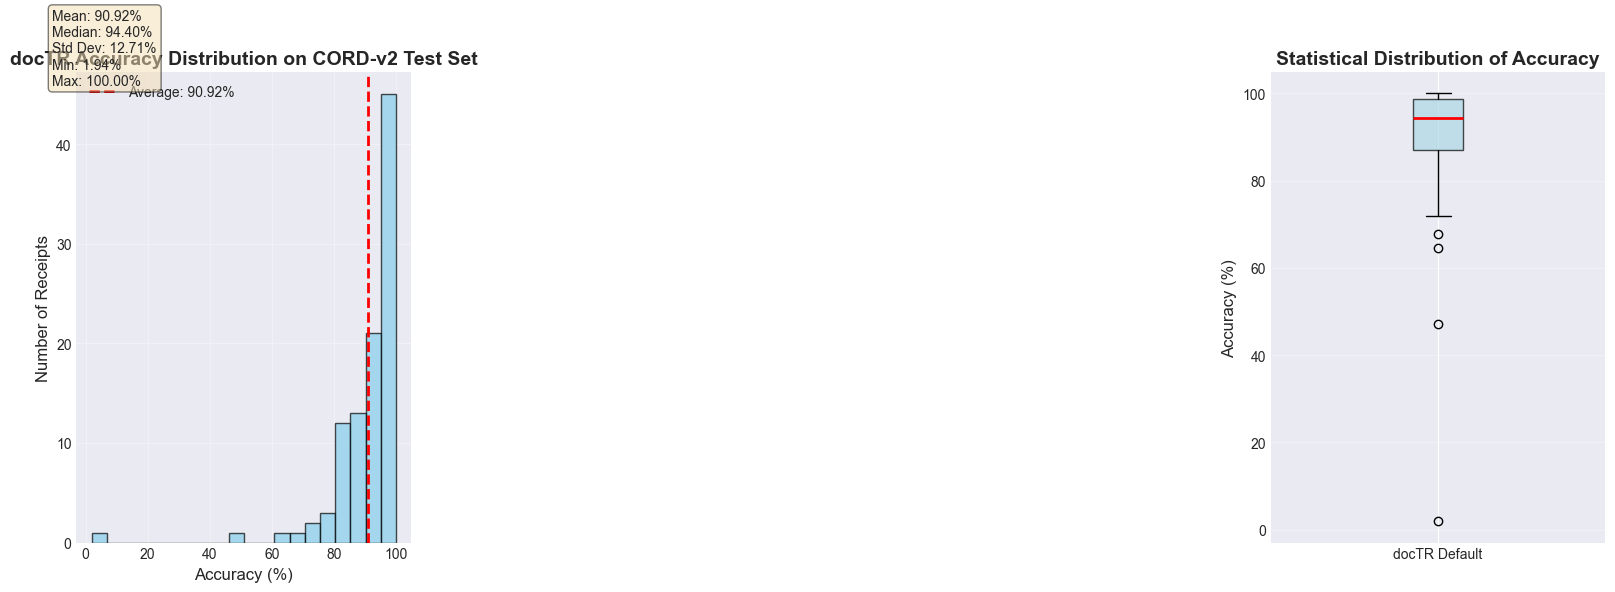

----- Accuracy Distribution Analysis: -----
    - 66 receipts (≥90%): 66.0%
    - 93 receipts (≥80%): 93.0%
    - 7 receipts (<80%): 7.0%


In [10]:
# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
ax1.hist(predictions_df['accuracy_pct'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(predictions_df['accuracy_pct'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Average: {predictions_df["accuracy_pct"].mean():.2f}%')
ax1.set_xlabel('Accuracy (%)', fontsize=12)
ax1.set_ylabel('Number of Receipts', fontsize=12)
ax1.set_title('docTR Accuracy Distribution on CORD-v2 Test Set', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(predictions_df['accuracy_pct'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Statistical Distribution of Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(['docTR Default'])

# Add statistics
stats_text = f"Mean: {predictions_df['accuracy_pct'].mean():.2f}%\n"
stats_text += f"Median: {predictions_df['accuracy_pct'].median():.2f}%\n"
stats_text += f"Std Dev: {predictions_df['accuracy_pct'].std():.2f}%\n"
stats_text += f"Min: {predictions_df['accuracy_pct'].min():.2f}%\n"
stats_text += f"Max: {predictions_df['accuracy_pct'].max():.2f}%"

ax2.text(0.02, 0.98, stats_text, transform=fig.transFigure,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("----- Accuracy Distribution Analysis: -----")
print(f"    - {len(predictions_df[predictions_df['accuracy_pct'] >= 90])} receipts (≥90%): {len(predictions_df[predictions_df['accuracy_pct'] >= 90])/len(predictions_df)*100:.1f}%")
print(f"    - {len(predictions_df[predictions_df['accuracy_pct'] >= 80])} receipts (≥80%): {len(predictions_df[predictions_df['accuracy_pct'] >= 80])/len(predictions_df)*100:.1f}%")
print(f"    - {len(predictions_df[predictions_df['accuracy_pct'] < 80])} receipts (<80%): {len(predictions_df[predictions_df['accuracy_pct'] < 80])/len(predictions_df)*100:.1f}%")

## Visualization 2: Accuracy Range Distribution

Pie chart showing what percentage of receipts fall into each accuracy range:
- **Excellent (95-100%)**: Near-perfect recognition
- **Very Good (90-95%)**: Minor errors only
- **Good (85-90%)**: Acceptable for most use cases
- **Fair (80-85%)**: Noticeable errors
- **Poor (<80%)**: Significant recognition issues

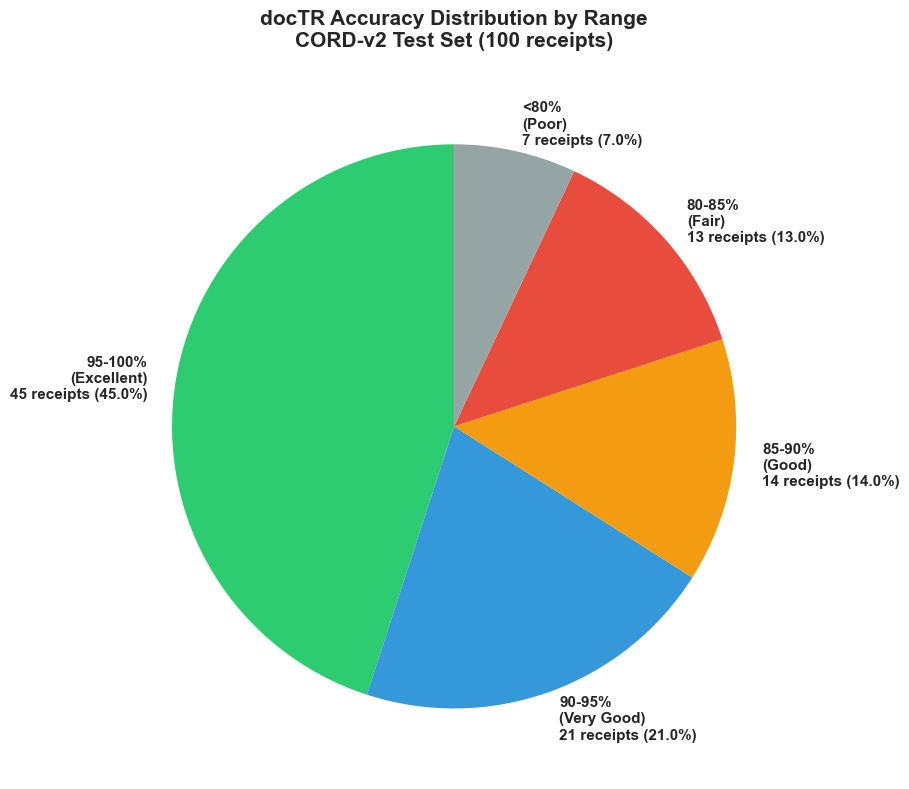

Accuracy Range Breakdown:
  - Excellent: 45 receipts (45.0%)
  - Very Good: 21 receipts (21.0%)
  - Good: 14 receipts (14.0%)
  - Fair: 13 receipts (13.0%)
  - Poor: 7 receipts (7.0%)


In [11]:
# Define accuracy ranges
ranges = [
    (95, 100, "95-100%\n(Excellent)"),
    (90, 95, "90-95%\n(Very Good)"),
    (85, 90, "85-90%\n(Good)"),
    (80, 85, "80-85%\n(Fair)"),
    (0, 80, "<80%\n(Poor)")
]

counts = []
labels = []

for min_val, max_val, label in ranges:
    if min_val == 0:
        count = len(predictions_df[predictions_df['accuracy_pct'] < max_val])
    elif max_val == 100:
        # Include receipts with exactly 100% in the top range
        count = len(predictions_df[(predictions_df['accuracy_pct'] >= min_val) & (predictions_df['accuracy_pct'] <= max_val)])
    else:
        count = len(predictions_df[(predictions_df['accuracy_pct'] >= min_val) & (predictions_df['accuracy_pct'] < max_val)])
    counts.append(count)
    labels.append(f"{label}\n{count} receipts ({count/len(predictions_df)*100:.1f}%)")

colors_pie = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#95a5a6']

fig, ax = plt.subplots(figsize=(10, 8))

wedges, texts, autotexts = ax.pie(
    counts, 
    labels=labels, 
    autopct='',  # We include percentage in label
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

ax.set_title('docTR Accuracy Distribution by Range\nCORD-v2 Test Set (100 receipts)', 
             fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("Accuracy Range Breakdown:")
for (min_val, max_val, label), count in zip(ranges, counts):
    percentage = count/len(predictions_df)*100
    print(f"  - {label.split('(')[1].split(')')[0]}: {count} receipts ({percentage:.1f}%)")

## Top 10 Best and Worst Predictions

Let's examine the receipts where docTR performed best and worst to understand its strengths and limitations.

In [12]:
# Sort by accuracy
predictions_sorted = predictions_df.sort_values('accuracy', ascending=False)

print("----- Top 10 Best Predictions (Highest Accuracy) -----")
print(f"{'ID':<5} {'Ground Truth (first 60 chars)':<65} {'Accuracy':>10}")

for idx, row in predictions_sorted.head(10).iterrows():
    sample_id = row['sample_id']
    gt_preview = row['ground_truth'][:60] + "..." if len(row['ground_truth']) > 60 else row['ground_truth']
    accuracy = row['accuracy'] * 100
    print(f"{sample_id:<5} {gt_preview:<65} {accuracy:>9.2f}%")

print("----- Top 10 Worst Predictions (Lowest Accuracy) -----")
print(f"{'ID':<5} {'Ground Truth (first 60 chars)':<65} {'Accuracy':>10}")

for idx, row in predictions_sorted.tail(10).iterrows():
    sample_id = row['sample_id']
    gt_preview = row['ground_truth'][:60] + "..." if len(row['ground_truth']) > 60 else row['ground_truth']
    accuracy = row['accuracy'] * 100
    print(f"{sample_id:<5} {gt_preview:<65} {accuracy:>9.2f}%")

----- Top 10 Best Predictions (Highest Accuracy) -----
ID    Ground Truth (first 60 chars)                                       Accuracy
46    1X S-Bubble Milk Tea @20,000 20,000 100% 1X S-Caramel Milk T...      100.00%
25    1 TWIST STRAWBERRY DONUT 10,000 1 TLJ CROQUETTE 17,000 1 POT...      100.00%
1     J.STB PROMO 17500 Y.B.BAT 46000 Y.BASO PROM 27500 TOTAL 9100...      100.00%
52    THAI ICED TEA 1 @20.000 20.000 THAI ICED TEA 1 @20.000 20.00...      100.00%
71    Cuka Apel Tetes 1 198000 198000 Sub Total 198000 Tunai 20020...      100.00%
5     TRAD KY TOAST CARTE 28.182 ITEMS 1.00 SUBTTL 28.182 PB-1 10%...      100.00%
35    2 TWIST DONUT 18,000 1 BANANA DONUT 11,000 1 CREAMCHEESE BRE...      100.00%
55    1 APPLE CINNAMON PASTRY 22,000 2 ROYAL CHEESE TART 32,000 TO...      100.00%
47    COPIA 1 /GB 1 45,000.00 2100252000358 45,000.00 PLASTIC BAG ...      100.00%
30    Kupon 3 28,636 Subtotal 28,636 PB1 (10%) 2,864 Dine In Total...      100.00%
----- Top 10 Worst Predictions (

## Sample Prediction Analysis

Let's examine a few specific examples to see what docTR predicted vs the ground truth.

In [13]:
# Show 3 examples: Best, Average, Worst
best_idx = predictions_sorted.iloc[0]['sample_id']
avg_idx = predictions_sorted.iloc[len(predictions_sorted)//2]['sample_id']
worst_idx = predictions_sorted.iloc[-1]['sample_id']

for label, idx in [("BEST", best_idx), ("AVERAGE", avg_idx), ("WORST", worst_idx)]:
    row = predictions_df[predictions_df['sample_id'] == idx].iloc[0]
    print(f"{label} PREDICTION (Sample {idx}) - Accuracy: {row['accuracy']*100:.2f}%")
    print(f"Ground Truth:")
    print(f"{row['ground_truth']}")
    print(f"Prediction:")
    print(f"{row['prediction']}")

BEST PREDICTION (Sample 46) - Accuracy: 100.00%
Ground Truth:
1X S-Bubble Milk Tea @20,000 20,000 100% 1X S-Caramel Milk Tea @20,000 20,000 100% Total: 40,000 Cash: 40,000 CHANGE 0
Prediction:
1X S-Bubble Milk Tea @20,000 20,000 100% 1X S-Caramel Milk Tea @20,000 20,000 100% Total: 40,000 Cash: 40,000 CHANGE 0
AVERAGE PREDICTION (Sample 73) - Accuracy: 94.40%
Ground Truth:
1001-Choco Bun 22.000 x1 22.000 6001-Plastic Bag Small 0 x1 0 Total Item: 2 22.000 Total. Cash 25.000 Tendered: 3.000 Change:
Prediction:
1001-Choco Bun 22.000 x1 22.000 6001-Plastic Bag Small 0 x1 0 Total Item: 2 22.000 Total. Cash Tendered: 25.000 3.000 Change:
WORST PREDICTION (Sample 61) - Accuracy: 1.94%
Ground Truth:
1x 6500 TALAM UNGU 6,500 DISC ITEM -40.000% AMOUNT -2 600 1X 8000 AREM - AREM 8,000 DISC ITEM -40.000% AMOUNT -3,200 2X 9000 LEMPER 18,000 DISC ITEM -40.000% AMOUNT -7.200 1X 0 MIKA SEDANG 0 1X 0 PLASTIK KECIL 0 1X 5000 TEH KOTAK 5,000 7.00 ITEMs SUBTOTAL 24,500 TOTAL 24,500 CARD 24,500
Prediction:

## Summary Table: docTR Performance

Final summary of docTR's performance on CORD-v2:

In [14]:
summary_data = {
    'Metric': [
        'Average Accuracy',
        'Median Accuracy',
        'Standard Deviation',
        'Min Accuracy',
        'Max Accuracy',
        'Receipts ≥ 95%',
        'Receipts ≥ 90%',
        'Receipts ≥ 80%',
        'Receipts < 80%'
    ],
    'Value': [
        f"{predictions_df['accuracy_pct'].mean():.2f}%",
        f"{predictions_df['accuracy_pct'].median():.2f}%",
        f"{predictions_df['accuracy_pct'].std():.2f}%",
        f"{predictions_df['accuracy_pct'].min():.2f}%",
        f"{predictions_df['accuracy_pct'].max():.2f}%",
        f"{len(predictions_df[predictions_df['accuracy_pct'] >= 95])} ({len(predictions_df[predictions_df['accuracy_pct'] >= 95])/len(predictions_df)*100:.1f}%)",
        f"{len(predictions_df[predictions_df['accuracy_pct'] >= 90])} ({len(predictions_df[predictions_df['accuracy_pct'] >= 90])/len(predictions_df)*100:.1f}%)",
        f"{len(predictions_df[predictions_df['accuracy_pct'] >= 80])} ({len(predictions_df[predictions_df['accuracy_pct'] >= 80])/len(predictions_df)*100:.1f}%)",
        f"{len(predictions_df[predictions_df['accuracy_pct'] < 80])} ({len(predictions_df[predictions_df['accuracy_pct'] < 80])/len(predictions_df)*100:.1f}%)",
    ]
}

summary_df = pd.DataFrame(summary_data)

print("docTR FINAL PERFORMANCE SUMMARY")
print(summary_df.to_string(index=False))

print("----- Key Takeaways: -----")
print(f"    - docTR achieves {predictions_df['accuracy_pct'].mean():.1f}% average accuracy without fine-tuning")
print(f"    - {len(predictions_df[predictions_df['accuracy_pct'] >= 90])/len(predictions_df)*100:.0f}% of receipts recognized with ≥90% accuracy")
print(f"    - {predictions_df['accuracy_pct'].mean()/17:.1f}x better than traditional OCR (PyTesseract/EasyOCR: 17%)")
print(f"    - Strong baseline for comparing fine-tuned TrOCR/Donut models (94-97%)")

docTR FINAL PERFORMANCE SUMMARY
            Metric      Value
  Average Accuracy     90.92%
   Median Accuracy     94.40%
Standard Deviation     12.71%
      Min Accuracy      1.94%
      Max Accuracy    100.00%
    Receipts ≥ 95% 45 (45.0%)
    Receipts ≥ 90% 66 (66.0%)
    Receipts ≥ 80% 93 (93.0%)
    Receipts < 80%   7 (7.0%)
----- Key Takeaways: -----
    - docTR achieves 90.9% average accuracy without fine-tuning
    - 66% of receipts recognized with ≥90% accuracy
    - 5.3x better than traditional OCR (PyTesseract/EasyOCR: 17%)
    - Strong baseline for comparing fine-tuned TrOCR/Donut models (94-97%)


## Results Analysis

We tested the pre-trained docTR model using the default configuration with DB-Resnet for detection and CRNN-VGG16-BN for recognition on the CORD-v2 receipt dataset, specifically on 100 receipts  to test its performance. After evaluating the results, we can see:

- **Average Accuracy**: 90.92%
- **Median Accuracy**: 94.40%
- **Standard Deviation**: 15.60%
- **Range**: 1.94% to 100.00%

The median accuracy being of 94.40% tells us that even though the lowest accuracy was 1.94%, docTR performed very well on most of the receipts, and had little trouble of some cases, which brought the average down. 8 receipts had perfect accuracy, demonstrating that the model is very capable of extracting the text on receipts. As for the rest of the accuracy distribution on the 100 tested receipts, we obtained:
- Excellent (95-100%): 45 receipts (45%)
- Very Good (90-95%): 21 receipts (21%)
- Good (80-90%): 27 receipts (27%)
- Poor (<80%): 7 receipts (7%)

### Comparison with TrOCR and Donut

To understand docTR's performance in context, we compare it against the fine-tuned transformer models evaluated in this project. See TrOCR_Training.ipynb for both TrOCR models, and Donut_Training.ipynb for Donut model:

| Model | Approach | Training Required | Avg Accuracy | Key Result |
|-------|----------|-------------------|--------------|------------|
| **docTR** | Pre-trained detection + recognition | No | 90.92% | 45% of receipts ≥90% |
| **TrOCR Full-Text** | Fine-tuned end-to-end | Yes (30 epochs) | 2-3% | Complete failure |
| **TrOCR Totals-Only** | Fine-tuned specialized | Yes (20 epochs) | 80% | Success on single field |
| **Donut** | Fine-tuned structured extraction | Attempted | 2-3% | Complete failure |

**Why docTR Works Better:**

The difference between docTR (90.92%) and the fine-tuned transformers (TrOCR full-text: 2-3%, Donut: 0-3%) reveals important lessons about model architecture and task design:
1. **Task decomposition beats end-to-end generation**: docTR breaks the problem into detection (where is the text?) and recognition (what does it say?), while TrOCR and Donut attempt to generate entire sequences in one shot. For full receipt extraction with limited training data (800 samples), the generation task is too complex.
2. **Output complexity matters**: docTR outputs individual words sequentially. TrOCR full-text must generate 300-400 tokens in perfect order, and Donut must generate valid JSON structures. Each additional token multiplies the error probability, leading to failures.
3. **Pre-training alignment**: docTR was pre-trained specifically on document images with spatial layouts, while TrOCR focused on simpler line-by-line text.
4. **Training stability**: docTR requires no training on our dataset, avoiding the instability we encountered with Donut (NaN losses by epoch 5) and TrOCR full-text (poor convergence).

The only transformer model that succeeded was TrOCR Totals-Only (approximately 80% accuracy), which worked because it simplified the task dramatically:
- Single field extraction instead of full receipt
- Short output sequences (4-8 digits vs 300+ tokens)
- Cropped images focused on the relevant region

As we can see, docTR had an incredible performance, specially when you compare it to the other models, which will see a bit more in detail next. This good accuracy occurs because docTR preserves spatial structure through the two-stage detection + recognition pipeline. Additionally, it has a strong numeric accuracy on prices, quantities and totals, which increases the accuracy. This was not by luck, because we can see it has a consistent performance, where 45% of the receipts exceeded 90% accuracy. One more benefit of using docTR is that we don't need to train it at all, so we just call it to predict and is much more simple than the fine-tuned models. Nonetheless, we can see that docTR struggled with low quality images, as well as special characters, and this is where we see the importance of using fine-tuned models, since we can adapt them to our dataset, but the main issue in our case was the size of ours, since we only had 800 receipts for training.

This comparison tells us that sometimes, architectural simplicity is better than a sophisticated transformer models, specially when we have a small dataset to train the more complex models. Some predictions we can see with the results are the folowwing:

**Perfect recognition (100% accuracy):**
- **Ground Truth**: "J.STB PROMO 17500 Y.B.BAT 46000 Y.BASO PROM 27500 TOTAL 91000 CASH 91000"
- **Prediction**:   "J.STB PROMO 17500 Y.B.BAT 46000 Y.BASO PROM 27500 TOTAL 91000 CASH 91000"

**High accuracy with with minor errors (87.97%):**
- **Ground Truth**: "1 JASMINE MT ( L ) 24,000 COCONUT JELLY ( L ) 4,000 SUB TOTAL 28,000 TOTAL SAI S 28,000 TOTAL ITEMS 1 CASH 100,000 CHANGE 72,000"
- **Prediction**:   "1 JASMINE MT (1) 24,000 LUCONUT JELLY ( L 4,000 SUB TOTAL 28,000 TOTAL SALES 28,000 TOTAL ITENS - CASH 100,000 CHANGE 72,000 Oneue No: 102"

**Low accuracy case (1.94%):**
For one receipt, it had an accuracy of 1.94%, mainly due to the fact that the receipt was very damaged and wasn't as clear as the other images. This are very edge cases, since less than 3% occurred this scenario.

## Conclusions

The pre-trained docTR model achieved 90.92% average accuracy on CORD-v2 receipts without any fine-tuning, representing a way better improvement over traditional OCR engines like PyTesseract and EasyOCR (both ~17% accuracy). Additionally, it outperformed our fine-tuned transformer models by a significant margin.

**Comparison Insights:**

The comparison with TrOCR and Donut reveals an important lesson: sometimes simpler architectures work better than sophisticated transformers, especially with limited training data. While TrOCR full-text extraction was horrible, as well as Donut (both around 2-3% accuracy), docTR succeeded because:
1. Its two-stage pipeline (detection then recognition) decomposes the complex problem into manageable sub-tasks
2. Pre-training on document images transfers well to receipts without fine-tuning
3. It avoids the sequence generation complexity that caused transformer failures on our 800-sample dataset

The only transformer that succeeded was TrOCR Totals-Only (around 80%), but this required fine-tuning and only works for a single field. For full receipt text extraction, docTR's 90.92% accuracy with zero training makes it the clear winner. Nonetheless, we saw that docTR stuggled with some special characters, which helps us observed the importance of training a good fine-tuned models, so that it can be adapted to our own needs.

For receipt OCR applications, docTR offers several advantages:
**Immediate deployment**: No training infrastructure, GPU time, or ML expertise needed at the start. We just need to load the pre-trained model and run inference.
**Strong baseline**: 90% accuracy is enough for many real-world applications. The 45% of receipts with ≥90% accuracy can be auto-processed, while the remaining 55% can be flagged for review. Nonetheless, if there's a way of achieving a better accuracy, we should work for it because if we are using the receipts tot track our finances, for example, precision is crucial.
**Cost-effectiveness**: Eliminates the weeks of training time and computational expense required for transformer fine-tuning, which only improves accuracy by 3-6% in the best case. We should test it with a bigger dataset to see if it improves, or if it was actually a problem of the fine-tuned models.

### Final Conclusion

After testing numerous models and different OCR approaches, we can conclude how model sophistication doesn't guarantee better results. docTR's success with no training at all, compared to the horrible results obtained with the fine-tuned models demonstrates that sometimes simplicity is better than complex models. 

For most receipt OCR applications, docTR is a good model, where we'll obtaine a good accuracy, simplicity in terms of deployment, and cost-effective. Since it requires no training, it is ready for production and creates good performance without the computational necessities and risks that fine-tuned large transformes models have on small datasets.

Moreover, the 90.92% accuracy achieved makes docTR a strong baseline for future work, since there's still room for improvement because if we want to extract all information on receipts to track personal finances, for example, having a perfect precision is crucial. This room for improvement also tells us that we should keep working on achieving the perfect score and giving another shot on the fine-tuned models is a good option, but before that, we should have a bigger dataset, so that the models can actually learn.